In [1]:
import os
import torch
import numpy as np
from evoaug import evoaug
from evoaug_analysis import utils, model_zoo

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_utilities/core/imports.py:116: UserWarning: Unbuilt egg for seqpro [unknown version] (/cellar/users/aklie/projects/ML4GLand/SeqPro)
  pkg_resources.require(self.requirement)
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_utilities/core/imports.py:116: UserWarning: Unbuilt egg for seqpro [unknown version] (/cellar/users/aklie/projects/ML4GLand/SeqPro)
  pkg_resources.require(self.requirement)


# Load the model
The DeepSTARR model take ins length 249 nt sequences and the output is 2 scalar values representing the activity of developmental enhancers and housekeeping enhancers measured experimentally using STARR-seq.

In [3]:
# Load the DeepSTARR model that was trained in the evo_aug paper
ckpt_path = "/cellar/users/aklie/projects/ML4GLand/models/deAlmeida22/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt"
deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(
    deepstarr, 
    criterion=loss, 
    optimizer=optimizer_dict, 
    augment_list=[]
)
# load model weights
standard_cnn = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path).eval()

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file projects/ML4GLand/models/deAlmeida22/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt`


# Load motifs: ETS, SREBP, GATA, AP-1 and Dref
See Supplementary table 10 of the DeepSTARR paper for the motif IDs (parially listed below). We will perform a distance-cooperativity analysis the four combinations of motifs listed in the paper:

1. ETS and SREBP
2. GATA and GATA
3. AP-1 and GATA
4. Dref and Dref

| TF motif | PWM model                                          | Collection name |
|----------|----------------------------------------------------|-----------------|
| AP-1     | jaspar__MA0476.1                                   | jaspar          |
| GATA     | flyfactorsurvey__srp_SANGER_5_FBgn0003507           | flyfactorsurvey |
| twist    | flyfactorsurvey__twi_da_SANGER_5_FBgn0000413        | flyfactorsurvey |
| Trl      | flyfactorsurvey__Trl_FlyReg_FBgn0013263             | flyfactorsurvey |
| SREBP    | flyfactorsurvey__HLH106_SANGER_10_FBgn0015234       | flyfactorsurvey |
| ETS      | flyfactorsurvey__Ets97D_SANGER_10_FBgn0004510       | flyfactorsurvey |
| Dref     | homer__AVYTATCGATAD_DREF                           | homer           |
| Ohler1   | homer__MYGGTCACACTG_Unknown1                       | homer           |
| Ohler6   | homer__AAAAATACCRMA_Unknown4                | homer           |

In [4]:
# We can use motifdata for the jaspar and homer motif databases
import motifdata as md

In [5]:
# From jaspar
ap1_motif = md.load_jaspar(motif_accs=["MA0476.1"])["MA0476.1"]
ap1_consensus = ap1_motif.consensus

# From flybase, had to do manual
gata_consensus = "TGATAAGG"
ets_consensus = "ACCGGAAGT"
srebp_consensus = "ATCACGCGAC"

# From homer
dref_motif = md.read_homer("/cellar/users/aklie/opt/homer/motifs/insects/dref.motif")["AVYTATCGATAD"]
dref_consensus = dref_motif.consensus

# Generate a name to consensus dictionary
name_to_consensus = {
    "AP-1": ap1_consensus,
    "GATA": gata_consensus,
    "ETS": ets_consensus,
    "SREBP": srebp_consensus,
    "DREF": dref_consensus
}

# Print out the consensus sequences
print(f"AP-1: {ap1_consensus}")
print(f"GATA: {gata_consensus}")
print(f"ETS: {ets_consensus}")
print(f"SREBP: {srebp_consensus}")
print(f"DREF: {dref_consensus}")

AP-1: TGTGACTCATT
GATA: TGATAAGG
ETS: ACCGGAAGT
SREBP: ATCACGCGAC
DREF: AACTATCGATAG


# Mode 1: ETS/SREBP -- synergize exclusively at close distances (<25 bp)

In [6]:
import xarray as xr
import seqpro as sp
from eugene import interpret
from eugene import plot as pl

In [7]:
# Analysis params
seq_number = 60
seq_len = 249
comparisons = [
    ("ETS", "SREBP"),
    ("GATA", "GATA"),
    ("AP-1", "GATA"),
    ("DREF", "DREF")
]

In [8]:
random_backbones = sp.random_seqs((seq_number, seq_len), alphabet=sp.alphabets.DNA, seed=42)
sdata = xr.Dataset({"seq": (["_sequence", "_length"], random_backbones)})

Running ('ETS', 'SREBP')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/220 [00:00<?…

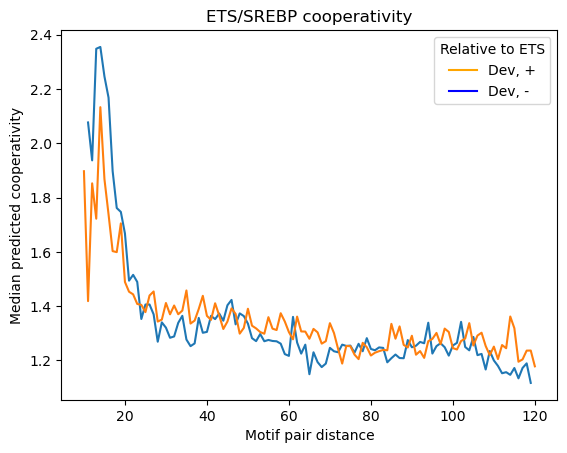

Running ('GATA', 'GATA')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/225 [00:00<?…

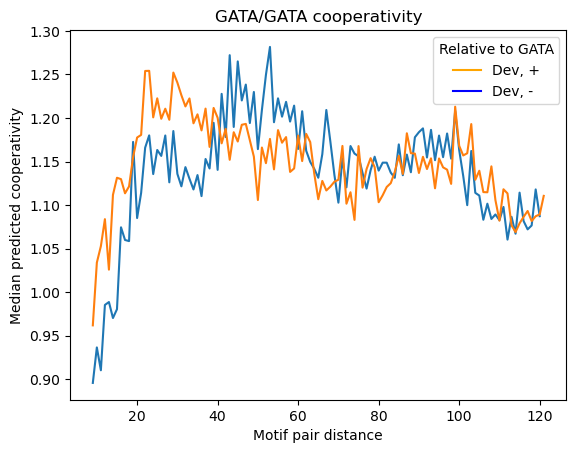

Running ('AP-1', 'GATA')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/222 [00:00<?…

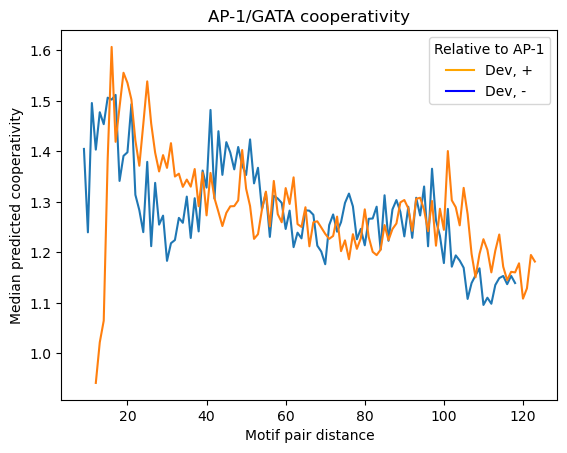

Running ('DREF', 'DREF')
Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/213 [00:00<?…

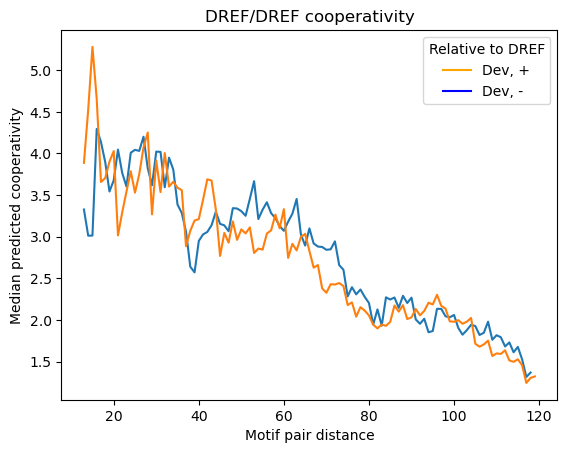

In [9]:
for comparison in comparisons:
    print(f"Running {comparison}")
    motif_a_name, motif_b_name = comparison

    # Run the GIA
    interpret.motif_distance_dependence_gia(
        model=standard_cnn,
        sdata=sdata,
        feature_A=name_to_consensus[motif_a_name],
        feature_B=name_to_consensus[motif_b_name],
        tile_step=1,
        style="deAlmeida22",
        seq_key="seq",
        results_key=f"{motif_a_name}_{motif_b_name}_cooperativity",
        distance_key=f"{motif_a_name}_{motif_b_name}_distance",
        device="cuda",
        batch_size=128
    )

    # Plot the results
    pl.distance_cooperativity_gia_plot(
        sdata,
        results_key=f"{motif_a_name}_{motif_b_name}_cooperativity",
        distance_key=f"{motif_a_name}_{motif_b_name}_distance",
        col_names=["Dev", "HK"],
        cols_to_plot=["Dev"],
        motif_a_name=motif_a_name,
        motif_b_name=motif_b_name
    )

# Scratch

In [106]:
# Function args
model = standard_cnn
feature_A = motif_a
feature_B = motif_b
tile_step = 1
style = "deAlmeida22"
seq_key = "seq"
results_key = "cooperativity"
device = "cpu"
batch_size = 128

In [107]:
# Make sure the backbones are compatible with the next function
backbones = np.array([b"".join(backbone) for backbone in sdata[seq_key].values]).astype('U')

In [108]:
# Do the embedding based on the passed in style
A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances = embed_deepstarr_distance_cooperativity(
    null_sequences=backbones,
    motif_a=feature_A,
    motif_b=feature_B,
    step=tile_step
)

In [109]:
# Get results that are dependent on the style
cooperativity_results = deepstarr_motif_distance_cooperativity_gia(
    model=standard_cnn,
    b_seqs=backbones,
    A_seqs=A_seqs,
    B_seqs=B_seqs,
    AB_seqs=AB_seqs,
    motif_b_distances=motif_b_distances,
    batch_size=128,
    device="cuda"
)

Getting background scores
Getting motif A scores


Calculating fold changes for each provided distance between MotifA and MotifB:   0%|          | 0/220 [00:00<?…

In [110]:
# Set up the xarray of the results
distances = np.array(list(cooperativity_results.keys()))
predictions = np.array(list(cooperativity_results.values()))
cooperativity_xr = xr.Dataset(
    data_vars = dict(results_key=(["_distance", "_sequence", "_predictions"], predictions),),
    coords = dict(distance=(["_distance"], distances))
)

In [122]:
sdata.assign_coords(distance=("_distance", distances))
sdata

<xarray.Dataset>
Dimensions:   (_sequence: 60, _length: 249, _distance: 220)
Coordinates:
    distance  (_distance) <U4 '-119' '-118' '-117' ... '+118' '+119' '+120'
Dimensions without coordinates: _sequence, _length, _distance
Data variables:
    seq       (_sequence, _length) |S1 b'A' b'T' b'G' b'C' ... b'T' b'C' b'G'

In [123]:
sdata.assign?

Signature:
sdata.assign(
    variables: 'Mapping[Any, Any] | None' = None,
    **variables_kwargs: 'Any',
) -> 'T_Dataset'
Docstring:
Assign new data variables to a Dataset, returning a new object
with all the original variables in addition to the new ones.

Parameters
----------
variables : mapping of hashable to Any
    Mapping from variables names to the new values. If the new values
    are callable, they are computed on the Dataset and assigned to new
    data variables. If the values are not callable, (e.g. a DataArray,
    scalar, or array), they are simply assigned.
**variables_kwargs
    The keyword arguments form of ``variables``.
    One of variables or variables_kwargs must be provided.

Returns
-------
ds : Dataset
    A new Dataset with the new variables in addition to all the
    existing variables.

Notes
-----
Since ``kwargs`` is a dictionary, the order of your arguments may not
be preserved, and so the order of the new variables is not well
defined. Assigning multiple

In [ ]:
sdata["cooperativity"] = xr.DataArray(predictions

In [118]:
sdata.set_coords(dict(distance=(["_distance"], distances)))

ValueError: These variables cannot be found in this dataset: ['distance']

In [111]:
# Merge the results with the original dataset
sdata_merged = xr.merge([sdata, cooperativity_xr])

In [71]:
import pandas as pd

In [79]:
cooperativity_df

,dev,hk,distance,relative_to_motif_a
0,1.117075,1.008569,119,-
1,1.189124,1.025121,118,-
2,1.172171,1.018319,117,-
3,1.133954,1.011066,116,-
4,1.171981,1.019377,115,-
...,...,...,...,...
215,1.195136,1.024285,116,+
216,1.203706,1.020146,117,+
217,1.236068,1.027832,118,+
218,1.236346,1.016066,119,+


In [ ]:
def cooperativity_gia_plot()